In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

#Data Preprocessing
##Reading in the data 
The data is combined because I will be using the pd.get_dummies function to get Dummy variables so this will prevent discrepancies later on.

In [2]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_y = train['SalePrice']
dataset = pd.concat([train, test], axis = 0, sort = False)
dataset = dataset.drop(['SalePrice'], axis = 1)
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal



##Handling Missing data
In this section I remove all columns missing more than 50% data to prevent hinderances in our model. I also get the dummy variables within the dataset and impute the most frequent values across columns to replace missing values.
 

<BarContainer object of 4 artists>

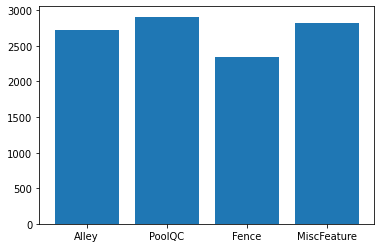

In [3]:
#Find all columns missing more than 50% of data and storing them in a variable
missingMajority = []
for i in range(dataset.shape[1]):
    if dataset.isnull().sum()[i] > dataset.shape[0] * 0.5:
        missingMajority.append(dataset.isnull().sum().keys()[i])
#visualize those columns
plt.bar(missingMajority, dataset[missingMajority].isnull().sum())


In [4]:
#Drop the columns from the dataset 
dataset = dataset.drop(columns = missingMajority, axis = 1)
dataset = pd.get_dummies(dataset)
columns = dataset.columns

#Use the imputer function to impute most frequent values across columns
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

dataset = imputer.fit_transform(dataset)

#Split the dataset back into training and test values
dataset = pd.DataFrame(dataset, columns= columns)
train_x = dataset.iloc[:1460, :]
test_x = dataset.iloc[1460: , :]
train_x = pd.DataFrame(train_x, columns = columns)
test_x = pd.DataFrame(test_x, columns = columns)
train_x.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


##Feature Selection
Now that the dataset is clean, I will select only the top features which best describe the dataset for usage in the model training.

<BarContainer object of 52 artists>

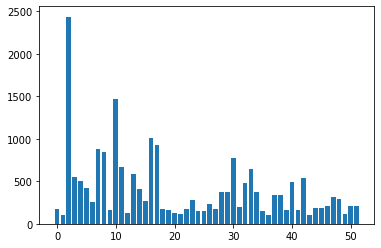

In [5]:
def best_feat(x_train, y_train, kval='all'):
    #A function that takes in an x and a y value and determines the best\
    #x values that explain the regression functions y_value.
    bestModel = SelectKBest(score_func = f_regression, k = kval)
    bestModel.fit(x_train, y_train)
    x_best = bestModel.transform(x_train)
    return x_best, bestModel

x_train, bestModel = best_feat(train_x, train_y)
bestScores=bestModel.scores_
plt.bar(range(len(bestScores[bestScores > 100])), bestScores[bestScores > 100])

In [0]:
x_train, bestModel = best_feat(train_x, train_y, kval=len(bestScores[bestScores > 100]))

#Model Selection and Tuning
##Model Selection
To decide which model will be ideal for the prediction, We will use cross validation to determine various models mean squared error and we will return the model with the lowest mse.*italicized text* 

In [0]:
#Define the various models we will use on the dataset
lr = LinearRegression()
rfr = RandomForestRegressor(criterion='mse')
svr = SVR()
lrp = LinearRegression()
ar = AdaBoostRegressor()

def crossVal(x, y, model):
    '''Takes in x and y and runs a 10fold cross validation on a given model. 
    Prints the mean mse and returns the 10 mse'''
    mse = cross_val_score(model, x, y, scoring = 'neg_mean_squared_error', \
                          cv=10, n_jobs = -1)
    print(model, mse.mean(), mse.std())
    return mse

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) -1168021303.6232152 866060558.2114499
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) -885282927.2829151 400826326.70346767
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) -6630037057.316629 1566383878.163345
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None) -1196171955.967471 353820537.38859

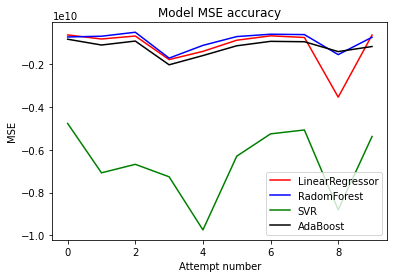

In [8]:
#We pass our training values and models to the function and get the mse ranges
rlr = crossVal(x_train, train_y, lr)
r2fr = crossVal(x_train, train_y, rfr)
rsvr = crossVal(x_train, train_y, svr)
rar = crossVal(x_train, train_y, ar)

plt.plot(rlr, c='red', label = 'LinearRegressor')
plt.plot(r2fr, c='blue', label = 'RadomForest')
plt.plot(rsvr, c='green', label = 'SVR')
plt.plot(rar, c='black', label = 'AdaBoost')
plt.xlabel('Attempt number')
plt.ylabel('MSE')
plt.title('Model MSE accuracy')
plt.legend()

From the graph, we can see our best model for this dataset will be a random forest regressor. 

##Model Tuning
Now we will move on to parameter tuning using GridSearchCV from sci-kit learn.


In [9]:
#We use sklearn's grid search to tune the parameter for n_estimators for an 
#improved mse score.
parameters = {'n_estimators': [100, 500, 1000]}
grid = GridSearchCV(rfr, param_grid=parameters,scoring='neg_mean_squared_error'\
                    , n_jobs=-1, cv=10)
grid.fit(x_train, train_y)
print('Best MSE score was {} and it was gotten from '.format(grid.best_score_))
print(grid.best_estimator_)
modelFin = grid.best_estimator_



Best MSE score was -852914646.3057263 and it was gotten from 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


#Predicting and getting results.

Now we fit our best model to the test set to predict the pricing of houses and save this values in a file. The file will be submitted on Kaggle and my test mse will be calculated.

In [10]:
x_test = bestModel.transform(test_x)
prediction = modelFin.predict(x_test)
sub = pd.concat([pd.DataFrame(np.int32(test_x['Id'])), pd.DataFrame(prediction)], axis = 1)
sub.columns = ['Id', 'SalePrice']
print(sub.head())
sub.to_csv('Submission.csv', index=False)

     Id   SalePrice
0  1461  126698.178
1  1462  152911.962
2  1463  181742.820
3  1464  184601.858
4  1465  198012.450


After submission on Kaggle, my model mean squared log error was 0.15409. This model can be improved with further parameter tuning on the Random Forest Classifier and also by selecting more or less features in the feature selection process.